In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import cartopy.crs as ccrs
import gsw
from eofs.xarray import Eof

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


from utils import *

In [2]:
ds_climatology = load_climatology_with_deptho().isel(depth=0)
ds_surface = load_surface_data()

In [3]:
ds_anomalies = ds_surface.groupby('time.month') - ds_climatology
ds_anomalies

<xarray.Dataset>
Dimensions:    (time: 252, latitude: 121, longitude: 1440)
Coordinates:
    depth      (time) float32 0.5058 0.5058 0.5058 ... 0.5058 0.5058 0.5058
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2023-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    S          (time, latitude, longitude) float32 0.2056 0.2059 ... -0.4106
    T          (time, latitude, longitude) float32 0.4319 0.4676 ... 0.03259
    SIC        (time, latitude, longitude) float32 -0.0006149 ... 0.001133
    SIT        (time, latitude, longitude) float32 -0.002763 ... -0.01426
    U          (time, latitude, longitude) float32 -0.02665 ... -0.0005737
    V          (time, latitude, longitude) float32 0.03762 ... -0.0001231
    SSH        (time, latitude, longitude) float32 -0.02152 -0.01225 ... 0.1164

## Global trend

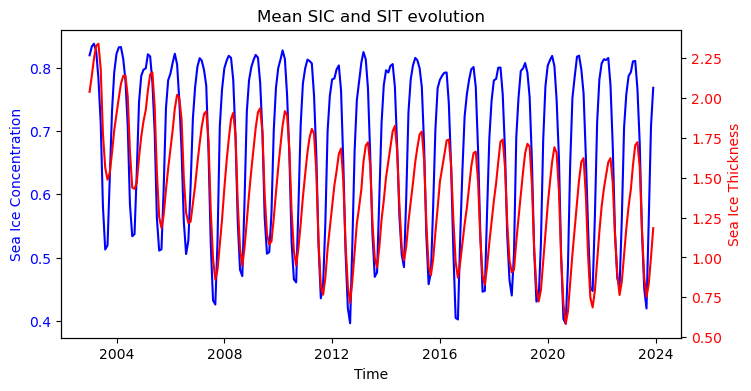

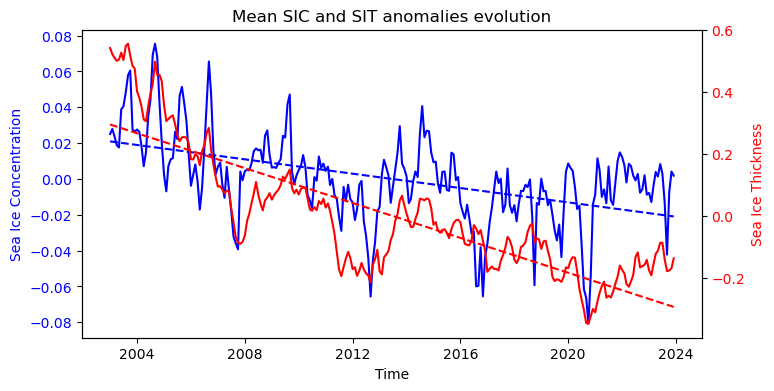

In [4]:
mean_SIC = ds_surface['SIC'].mean(['latitude', 'longitude'])
mean_SIT = ds_surface['SIT'].mean(['latitude', 'longitude'])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
axL, axR = ax, ax.twinx()
axL.plot(mean_SIC.time, mean_SIC, color='b', label='Mean SIC')
axR.plot(mean_SIT.time, mean_SIT, color='r', label='Mean SIT')

ax.set_xlabel('Time')
axL.set_ylabel('Sea Ice Concentration', color='b')
axL.tick_params(axis='y', labelcolor='b')
axR.tick_params(axis='y', labelcolor='r')
axR.set_ylabel('Sea Ice Thickness', color='r')
plt.title('Mean SIC and SIT evolution')
plt.show()

mean_SIC = ds_anomalies['SIC'].mean(['latitude', 'longitude'])
mean_SIT = ds_anomalies['SIT'].mean(['latitude', 'longitude'])

SIC_linear_coefs = np.polyfit(mean_SIC.time.astype('int64'), mean_SIC, 1)
SIT_linear_coefs = np.polyfit(mean_SIT.time.astype('int64'), mean_SIT, 1)

SIC_linear_trend = np.polyval(SIC_linear_coefs, mean_SIC.time.astype('int64'))
SIT_linear_trend = np.polyval(SIT_linear_coefs, mean_SIT.time.astype('int64'))

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
axL, axR = ax, ax.twinx()
axL.plot(mean_SIC.time, mean_SIC, color='b', label='Mean SIC')
axR.plot(mean_SIT.time, mean_SIT, color='r', label='Mean SIT')
axL.plot(mean_SIC.time, SIC_linear_trend, color='b', linestyle='--', label='SIC linear trend')
axR.plot(mean_SIC.time, SIT_linear_trend, color='r', linestyle='--', label='SIT linear trend')

ax.set_xlabel('Time')
axL.set_ylabel('Sea Ice Concentration', color='b')
axL.tick_params(axis='y', labelcolor='b')
axR.tick_params(axis='y', labelcolor='r')
axR.set_ylabel('Sea Ice Thickness', color='r')
plt.title('Mean SIC and SIT anomalies evolution')
plt.show()



La banquise perd plus vite en volume qu'en surface ??

## Anomalies std

In [5]:
ds_anomalies_std = ds_anomalies.std('time')

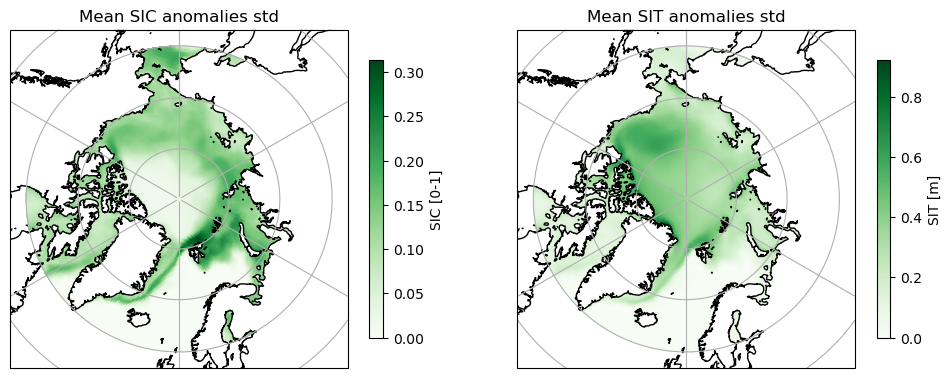

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs[0]
pcm = ax.pcolormesh(ds_anomalies_std['longitude'], ds_anomalies_std['latitude'], ds_anomalies_std['SIC'], cmap='Greens', transform=ccrs.PlateCarree())
plt.colorbar(pcm, ax=ax, label='SIC [0-1]', shrink=0.6)
ax.set_title('Mean SIC anomalies std')
ax.coastlines()
ax.gridlines()

ax = axs[1]
pcm = ax.pcolormesh(ds_anomalies['longitude'], ds_anomalies['latitude'], ds_anomalies_std['SIT'], cmap='Greens', transform=ccrs.PlateCarree())
plt.colorbar(pcm, ax=ax, label='SIT [m]', shrink=0.6)
ax.set_title('Mean SIT anomalies std')
ax.coastlines()
ax.gridlines()

plt.show()


## Anomalies map

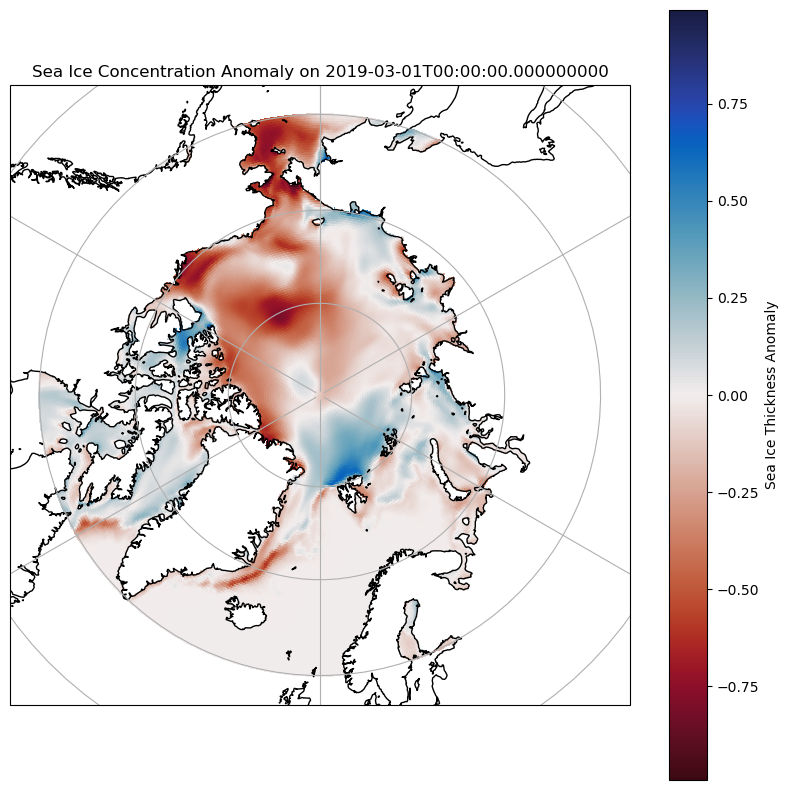

In [7]:
# random date
date = np.random.choice(ds_anomalies.time.values)

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    ds_anomalies.longitude, 
    ds_anomalies.latitude, 
    ds_anomalies.sel(time=date)['SIT'], 
    transform=ccrs.PlateCarree(), 
    cmap=cmo.balance.reversed(),
    vmin = -np.abs(ds_anomalies.sel(time=date)['SIT']).max(),
    vmax = np.abs(ds_anomalies.sel(time=date)['SIT']).max()
)
plt.colorbar(pcm, ax=ax, label='Sea Ice Thickness Anomaly')
plt.title(f'Sea Ice Concentration Anomaly on {date}')
plt.show()


## Distributions

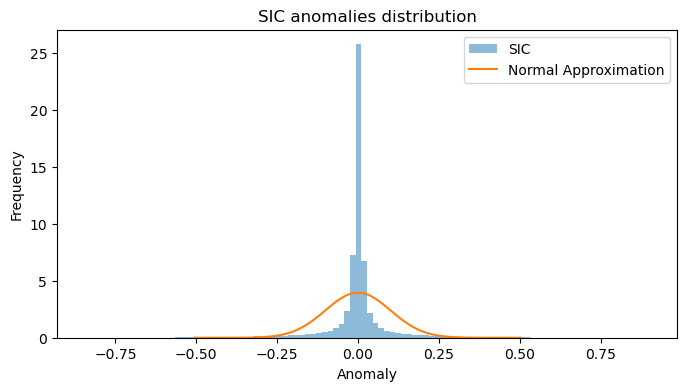

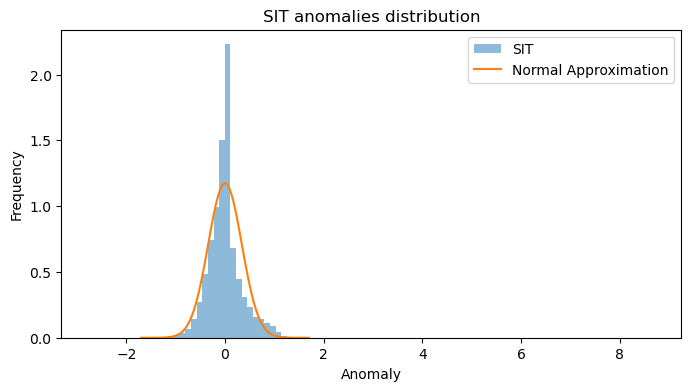

In [8]:
SIC_all_values = ds_anomalies['SIC'].values.flatten()
SIT_all_values = ds_anomalies['SIT'].values.flatten()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(SIC_all_values, bins=100, alpha=0.5, label='SIC', density=True)
mu, sigma = np.nanmean(SIC_all_values), np.nanstd(SIC_all_values)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
ax.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)), label='Normal Approximation')
ax.set_xlabel('Anomaly')
ax.set_ylabel('Frequency')
plt.title('SIC anomalies distribution')
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(SIT_all_values, bins=100, alpha=0.5, label='SIT', density=True)
mu, sigma = np.nanmean(SIT_all_values), np.nanstd(SIT_all_values)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
ax.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)), label='Normal Approximation')
ax.set_xlabel('Anomaly')
ax.set_ylabel('Frequency')
plt.title('SIT anomalies distribution')
plt.legend()
plt.show()

## EOFs on trended data

In [9]:
eof_solver = Eof(ds_anomalies['SIT'])

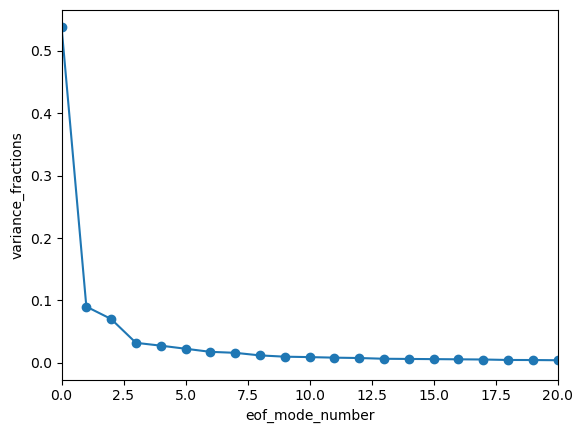

In [10]:
eof_solver.varianceFraction().plot(marker='o')
plt.xlim(0, 20)
plt.show()

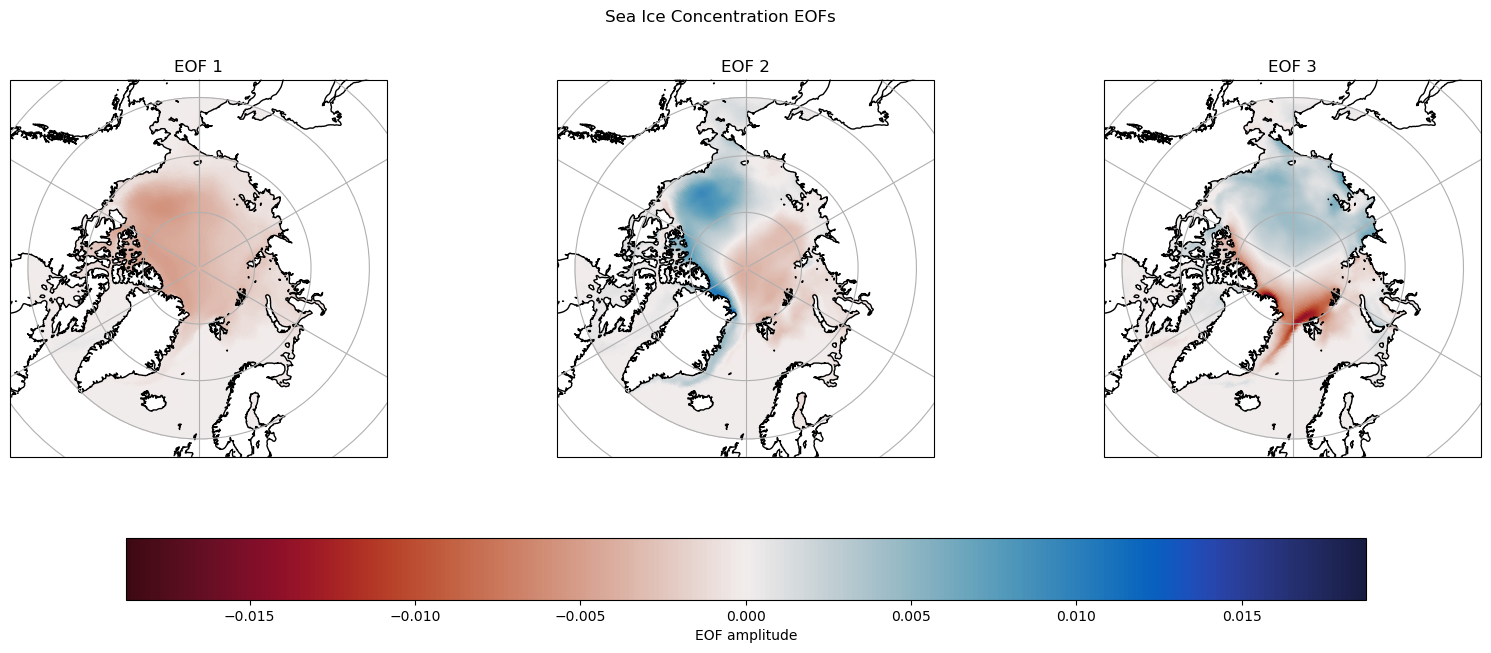

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})

max_val = np.abs(eof_solver.eofs()[:3]).max()

for i in range(3):
    ax = axs[i]
    ax.coastlines()
    ax.gridlines()
    pcm = ax.pcolormesh(
        ds_anomalies.longitude, 
        ds_anomalies.latitude, 
        eof_solver.eofs()[i], 
        transform=ccrs.PlateCarree(), 
        cmap=cmo.balance.reversed(),
        norm=colors.Normalize(vmin=-max_val, vmax=max_val),
    )
    ax.set_title(f'EOF {i+1}')
plt.colorbar(pcm, ax=axs, label='EOF amplitude', orientation='horizontal', shrink=0.8)
plt.suptitle('Sea Ice Concentration EOFs')
plt.show()

Les EOFs expliquent bien la variabilité visualisée sur la carte de std

L'EOF 1 correspond à une fonte globale de la banquise, on s'attend à ce que la PC associée soit croissante du temps.

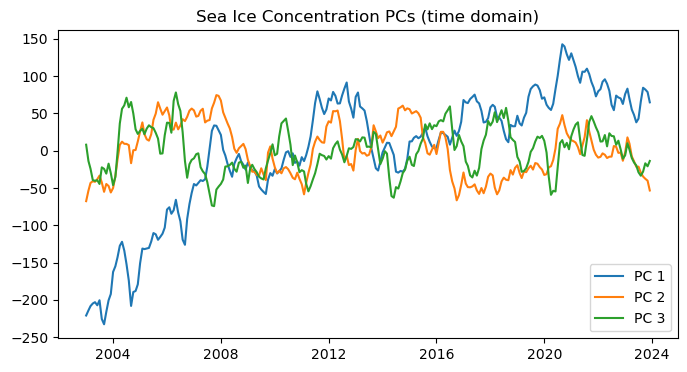

In [12]:
from scipy.fft import fft, fftfreq

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for i in range(3):
    ax.plot(ds_anomalies.time, eof_solver.pcs()[:, i], label=f'PC {i+1}')
plt.legend()
plt.title('Sea Ice Concentration PCs (time domain)')
plt.show()


Effectivement, le mode 1 augmente bien au cours du temps : signature du réchauffement climatique

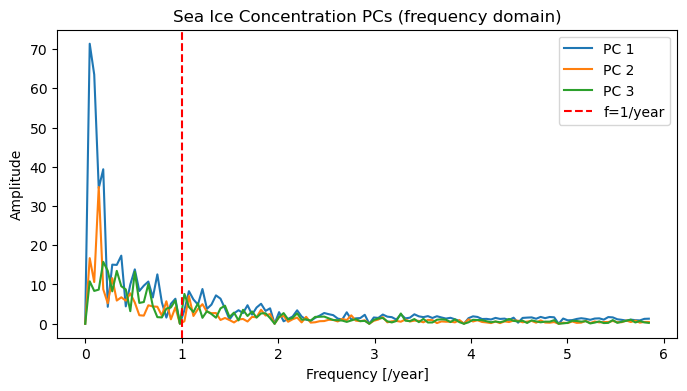

In [13]:

# Number of sample points
N = len(ds_anomalies.time)
# Sample spacing
T = (ds_anomalies.time[1] - ds_anomalies.time[0]).values.astype('timedelta64[D]').astype(int) / 365.25

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for i in range(3):
    yf = fft(eof_solver.pcs()[:, i].values)
    xf = fftfreq(N, T)[:N//2]
    ax.plot(xf, 2.0/N * np.abs(yf[:N//2]), label=f'PC {i+1}')

ax.axvline(x=1, color='r', linestyle='--', label='f=1/year')
plt.legend()
plt.title('Sea Ice Concentration PCs (frequency domain)')
plt.xlabel('Frequency [/year]')
plt.ylabel('Amplitude')
plt.show()

surtout de la variabilité interannuelle (peu de variabilité intraannuelle)